In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

# Load the dataset
data = pd.read_csv('/content/AWM_train.csv')

# Inspect the data
print(data.head())

                                                Text        Class
0  നവ്യയുടെ കയ്യിന്ന് കിട്ടിയതാണല്ലോ. ഇവൾക്ക് അതൊ...      Abusive
1  "ഇവരുടെ പ്രശ്നം അസൂയ ആണ്, സുന്ദരികൾ ആയ നടിമാരോ...      Abusive
2  ചുമ്മാതല്ല ഇവളെ പണ്ട് ലവർ അലക്കി വിട്ടത്...വായ...      Abusive
3  "ഒരു സിനിമയിൽ ജഗതി മദാമ്മയായിട്ട് വരുന്നുണ്ടല്...  Non-Abusive
4  ഈ വർഷത്തെ ബൂലോക തോൽവി പരാജയം അതിനുള്ള ഓസ്‌ക്കാ...      Abusive


In [ ]:
data.isnull().sum()

,0
Text,0
Class,0


In [ ]:
data.describe()

,Text,Class
count,2933,2933
unique,2933,2
top,ഡോക്ടർ റോബിന് ഭ്രാന്ത് ആണെന്ന് പറഞ്ഞപ്പോ ഇത്രേ...,Abusive
freq,1,1531


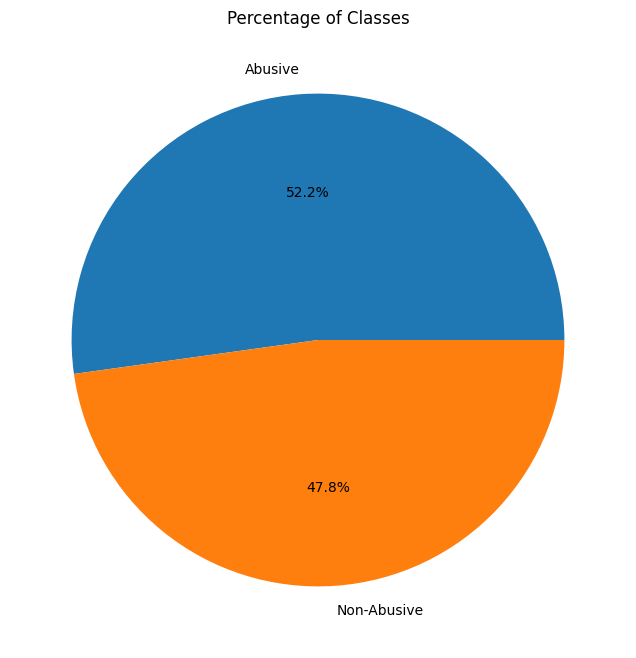

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each diagnosis
Class_counts = data['Class'].value_counts()



# Pie chart
Class_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Percentage of Classes')
plt.ylabel('')  # Hide y-axis label for better appearance
plt.show()

In [ ]:
# Map 'Abusive' to 1 and 'Non-Abusive' to 0
data['Class'] = data['Class'].map({'Abusive': 1, 'Non-Abusive': 0})

In [ ]:
data.head(5)

,Text,Class
0,നവ്യയുടെ കയ്യിന്ന് കിട്ടിയതാണല്ലോ. ഇവൾക്ക് അതൊ...,1
1,"""ഇവരുടെ പ്രശ്നം അസൂയ ആണ്, സുന്ദരികൾ ആയ നടിമാരോ...",1
2,ചുമ്മാതല്ല ഇവളെ പണ്ട് ലവർ അലക്കി വിട്ടത്...വായ...,1
3,"""ഒരു സിനിമയിൽ ജഗതി മദാമ്മയായിട്ട് വരുന്നുണ്ടല്...",0
4,ഈ വർഷത്തെ ബൂലോക തോൽവി പരാജയം അതിനുള്ള ഓസ്‌ക്കാ...,1


In [ ]:
# Assuming the dataset has 'Text' and 'Class' columns
texts = data['Text'].astype(str).tolist()
labels = data['Class'].tolist()

In [ ]:
# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:
# Load the MuRiL tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the data
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

In [ ]:
# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

In [ ]:
# Create a PyTorch dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)


In [ ]:
# Updated training arguments with lower learning rate and higher epochs
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,  # Lower learning rate
    per_device_train_batch_size=32,  # Larger batch size
    per_device_eval_batch_size=32,
    num_train_epochs=10,  # More epochs
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define a function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = (preds == labels).mean()
    return {"accuracy": acc}

In [ ]:
from transformers import EarlyStoppingCallback
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.668700,0.664631,0.652470
2,0.579800,0.592918,0.700170
3,0.436600,0.588719,0.706985
4,0.448400,0.626697,0.686542
5,0.282400,0.656140,0.710392
6,0.288200,0.712466,0.703578


TrainOutput(global_step=444, training_loss=0.46269613933992815, metrics={'train_runtime': 480.085, 'train_samples_per_second': 48.866, 'train_steps_per_second': 1.541, 'total_flos': 925887803811840.0, 'train_loss': 0.46269613933992815, 'epoch': 6.0})

In [ ]:
# Evaluate on the validation set
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.5887190103530884, 'eval_accuracy': 0.706984667802385, 'eval_runtime': 3.5921, 'eval_samples_per_second': 163.413, 'eval_steps_per_second': 5.289, 'epoch': 6.0}


In [ ]:
# Testing with another dataset
test_data = pd.read_csv('/content/AWM_dev.csv')

test_data.isnull().sum()



,0
Text,0
Class,0


In [ ]:
test_data['Class'] = test_data['Class'].map({'Abusive': 1, 'Non-Abusive': 0})
test_texts = test_data['Text'].astype(str).tolist()
test_labels = test_data['Class'].tolist()

In [ ]:
# Tokenize the test data
test_encodings = tokenize_function(test_texts)
test_labels = torch.tensor(test_labels)
test_dataset = TextDataset(test_encodings, test_labels)

In [ ]:
# Predictions on the test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)


In [ ]:

# Classification report
print(classification_report(test_labels, preds, target_names=['Non-Abusive', 'Abusive']))



              precision    recall  f1-score   support

 Non-Abusive       0.73      0.84      0.78       326
     Abusive       0.79      0.66      0.72       303

    accuracy                           0.75       629
   macro avg       0.76      0.75      0.75       629
weighted avg       0.76      0.75      0.75       629



In [ ]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_labels, preds))

Confusion Matrix:
[[273  53]
 [103 200]]


Confusion Matrix:
[[247  79]
 [ 93 210]]

 Confusion Matrix:
[[221 105]
 [ 75 228]]

In [ ]:
# Load the unlabeled dataset
unlabeled_data = pd.read_csv('/content/AWM_test_without_labels.csv')

# Extract the 'Text' column
unlabeled_texts = unlabeled_data['Text'].astype(str).tolist()

# Tokenize the unlabeled dataset
unlabeled_encodings = tokenize_function(unlabeled_texts)

In [ ]:
# Create a dataset object for the unlabeled data
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

unlabeled_dataset = UnlabeledDataset(unlabeled_encodings)

In [ ]:
# Predict on the unlabeled data
unlabeled_predictions = trainer.predict(unlabeled_dataset)
unlabeled_preds = np.argmax(unlabeled_predictions.predictions, axis=1)


In [ ]:
# Map predictions back to labels (0: 'Non-Abusive', 1: 'Abusive')
unlabeled_data['Labels'] = unlabeled_preds
unlabeled_data['Labels'] = unlabeled_data['Labels'].map({0: 'Non-Abusive', 1: 'Abusive'})


In [ ]:
unlabeled_data.head(5)

,id,Text,Labels
0,1,സൂരജ് നിന്റെ ആര് ആണ് ആള് ഇറക്കി പേടിപ്പിക്കുക ആണോ,Non-Abusive
1,2,എത്ര അലക്കി വെളുപ്പിച്ചാലും നിനക്കു അർഹത ഇല്ലാ...,Abusive
2,3,50 ലക്ഷം കയ്യിൽ വയ്ക്കാൻ ഒരിക്കലും യോഗ്യത ഇല്ല...,Non-Abusive
3,4,"""ബിഗ് ബോസ്സിൽ നിങ്ങളുടെ അഭിനയം എന്തായിരുന്നു,മ...",Abusive
4,5,അത് അങ്ങനെയാ നമ്മുടെ ഉള്ളിൽ നന്മ ഉണ്ടെങ്കിൽ പട...,Non-Abusive


In [ ]:
unlabeled_data.drop('Text',
  axis='columns', inplace=True)


In [ ]:
unlabeled_data.head(5)

,id,Labels
0,1,Non-Abusive
1,2,Abusive
2,3,Non-Abusive
3,4,Abusive
4,5,Non-Abusive


In [ ]:
# Save the results to a CSV file
unlabeled_data.to_csv('/content/results/predicted_results.csv', index=False)

print("Predictions saved to /content/results/predicted_results.csv")

Predictions saved to /content/results/predicted_results.csv


In [ ]:
'''# Get confidence scores
confidence_scores = torch.softmax(torch.tensor(unlabeled_predictions.predictions), dim=1).numpy()
max_confidences = np.max(confidence_scores, axis=1)

# Add confidence scores to the DataFrame
unlabeled_data['Confidence'] = max_confidences

# Save results with confidence scores
unlabeled_data.to_csv('/content/results/predicted_with_confidence.csv', index=False)
'''


"# Get confidence scores\nconfidence_scores = torch.softmax(torch.tensor(unlabeled_predictions.predictions), dim=1).numpy()\nmax_confidences = np.max(confidence_scores, axis=1)\n\n# Add confidence scores to the DataFrame\nunlabeled_data['Confidence'] = max_confidences\n\n# Save results with confidence scores\nunlabeled_data.to_csv('/content/results/predicted_with_confidence.csv', index=False)\n"